# Statistik mit Python

## Verteilungen und Darstellungen

----

#### Prof. Christian Münker, 25.7. 2017

In [50]:
from __future__ import print_function, division
# show plot in notebook instead of separate windows:
%matplotlib inline
import random
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt, pi
import scipy
import scipy.stats

#plt.style.use('seaborn-whitegrid')
plt.style.use('classic')#('seaborn-dark')
plt.rcParams['figure.figsize'] = (12.0, 5.0) # Plotgröße in Inch
#print(plt.style.available) # alle Matplotlib styles

In [51]:
# globale Variablen
N = 140      # Anzahl der Verzögerungselemente (Bins)
L = 2**14    # Anzahl der Messungen (= Versuche)
T_max = 2e-9 # maximale Messdauer einer Verzögerungskette

T_bin = T_max / N # durchschnittliche Verzögerung eines Elements
p_i = 1./N   # mittlere Wahrscheinlichkeit das Bin i zu treffen


# Verteilungen in Python

Im Paket `scipy.stats` sind u.a. die folgenden statistischen Verteilungen enthalten:

Verteilung  |	SciPy | zusätzliche Parameter
------------|:-------:|--------------------------
Beta	    | beta  | shape1, shape2
Bernoulli   | bernoulli | size, prob, ohne scale
Binomial    | binom | size, prob	
Chi-squared	| chi2	| df
Exponential	| expon	|
Gamma |	gamma |	shape
Log-normal|	lognorm |	sdlog	
Normal |	norm|
Poisson	|poisson |	lambda
Student t	| t	| df
Uniform	| unif	|

Für fast alle Verteilungen kann man Mittelwert (`loc=0`) und Skalierung (`scale=1`) angeben, einige erfordern zusätzliche Parameter (siehe Tabelle).

Die Verteilungen unterstützen u.a.die folgenden Methoden:


Scipy  | Keyword-Arg | Bedeutung
------ |:-----------:|:--------------------------------------------
pdf	   | x|Probability density function (kontinuierliche Verteilungen),<br>x ist Skalar oder Array
pmf    | (arg) |Probability mass function (diskrete Verteilungen) `arg` ist Skalar oder Array
cdf	   | x |Cumulative distribution function
sf	   | x |Survival function, komplementär zu cdf (sf = 1 - cdf), <br> liefert in manchen Fällen genauere Ergebnisse
ppf	   | q |Percentile Point Funktion (i.e. CDF inverse): In welchem Bereich $-\infty ... x$ <br> liegt der Teil `q` der Distribution
interval | alpha | Endpunkte des Bereichs, in dem der Teil `alpha` (0 ... 1) der Verteilung liegt
isf	   | q | Inverse survival function (Complementary CDF inverse)
stats  | moments='mv'| Mean ('m'), variance ('v'), skew ('s), kurtosis ('k') (als Tuple ausgegeben)
median | --- |Median
mean   | --- | Mittelwert
var    |--- | Varianz
std    |--- | Standardabweichung
moment | n | Moment der Ordnung `n`
rvs	   | size |Random samples

Verteilungen können als normale oder als *frozen functions* benutzt werden; bei letzteren sind Mittelwert und Skalierung "eingefroren". Beispiel für eine Normalverteilung mit $m=3$ und $\sigma=0.4$:

Mittelwert	= 3.0
95% Perzentil	= 3.657941450780589
Varianz		= 0.16
CDF(x=3)	= 0.5
Interval mit 90% der Verteilung: x = 2.34206 ... 3.65794


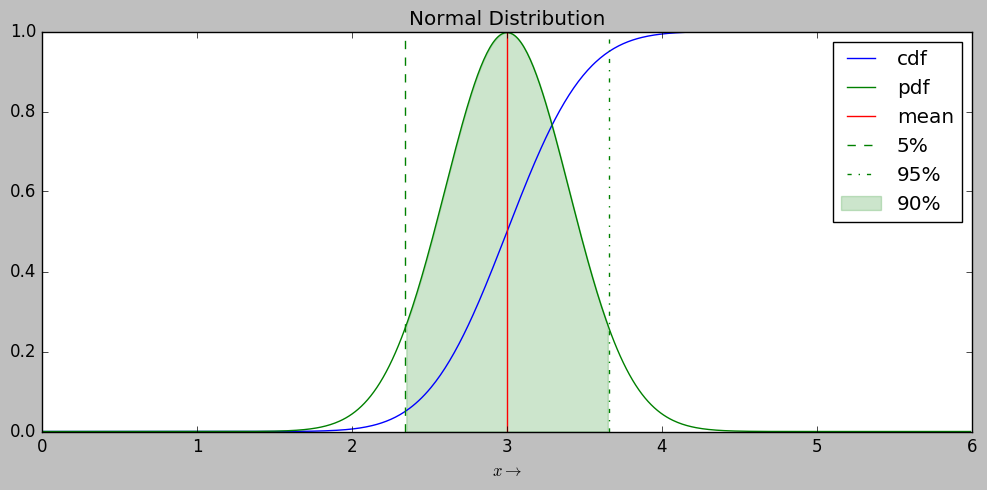

In [52]:
m = scipy.stats.norm.mean(loc=3, scale=0.4) # Mittelwert
pp95 = scipy.stats.norm.ppf(q=0.95, loc=3, scale=0.4) # für welches Argument ist die CDF = 0.5?
print("Mittelwert\t= {0}".format(m)) 
print("95% Perzentil\t= {0}".format(pp95)) 

mynorm = scipy.stats.norm(loc=3, scale=0.4) # Definiere frozen distribution mit m = 3 und sigma = 0.4
interval90 = mynorm.interval(alpha = 0.9)
print("Varianz\t\t= {0:g}".format(mynorm.var()))
print("CDF(x=3)\t= {0}".format(mynorm.cdf(x=3)))
print("Interval mit 90% der Verteilung: x = {0:g} ... {1:g}".format(interval90[0], interval90[1]))

fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
x = np.arange(0,6, 1e-2)
ax1.plot(x, mynorm.cdf(x), label='cdf')
ax1.plot(x, mynorm.pdf(x), label='pdf')
ax1.axvline(x=3, color = 'r', label='mean')
ax1.axvline(x=interval90[0], color='g', linestyle='--', label='5%')
ax1.axvline(x=interval90[1], color='g', linestyle='-.', label='95%')
ax1.fill_between(x, 0, mynorm.pdf(x), where = (x>interval90[0])&(x<interval90[1]), alpha=0.2, 
                 color = 'g', label='90%')
ax1.set_xlabel(r"$x \rightarrow$")
ax1.set_title("Normal Distribution")
ax1.legend(loc='best');



# Statistische Kalibration
----
Nicht immer ist es möglich oder praktisch, für eine Messung oder Kalibration Testdaten mit genau bestimmten vorhersagbaren (deterministischen) Eigenschaften zu verwenden. Oft sind zufällig verteilte Daten genauso gut oder besser geeignet, wenn deren statistische Momente bekannt sind und man die Zielgröße aus Häufigkeiten herauslesen kann.

## Stichproben aus Zufallsverteilungen (Sampling from Distributions) #
----
Mit unendlich vielen zufälligen Daten würde man in den meisten Fällen eine perfekte Auflösung erzielen. So viel Zeit hat man i.A. nicht und muss sich statt dessen mit einer *Stichprobe* begnügen und daraus die Eigenschaften der Verteilung *schätzen*. Eine der wichtigsten Fragen ist dabei, welches Vertrauen man in die Ergebnisse setzen kann, also mit welcher Wahrscheinlichkeit das Ergebnis dem für unendlich viele Messwerte entspricht.

In `scipy.stat` kann man für alle Verteilungen mit der Methode `rvs()` (*random variates*) Stichproben beliebiger Größe (parameter `size`) erzeugen. Die Stichproben sind (pseudo-)zufällig, d.h. jedes Mal werden neue Ergebnisse produziert. Je nach Verteilung können weitere Parameter angegeben werden wie `loc` (Mittelwert) oder `p` (Wahrscheinlichkeit).

## Bernoulli-Verteilung ##
 
Kann eine Zufallsvariable bei einem Versuch nur die Werte 0 oder 1 annehmen, $Y_i \in [0,1]$, und ist die Wahrscheinlichkeit für einen "Erfolg" $p = P(Y_i = 1)$ konstant, dann ist $Y_i$ eine *Bernoulli-Verteilung*. 

Beispiele: 
- Münzwurf ("Kopf", $p = 0.5$)
- Würfel ("Sechs", $p = 1/6$)
- TDC mit $N$ gleich breiten Bins, die den Zeitbereich $0 \ldots T_0$ abdecken. Das zu messende Zeitintervall ist eine kontinuierliche, gleichverteilte Größe $T_M \in [0 \ldots T_0]$. Die Wahrscheinlichkeit Bin $i$ zu treffen ist $p = 1/N$. 

Die komplementäre Wahrscheinlichkeit ("Misserfolg") ist definiert als $q = P(Y_i = 0) = 1 - p$.

`bern = scipy.stats.bernoulli(p=0.2)` definiert die Verteilung (*frozen distribution* da der Parameter `p` bereits festgelegt ist).

Mit `bern.rvs(size = 1000)` generiert man eine Stichprobe mit der angegebenen Verteilung und 1000 Elementen.

Der folgende Code zeigt ein Beispiel für eine Stichprobe der Größe 10 aus einer Bernoulli - Verteilung mit der Wahrscheinlichkeit `p=0.2`. Man erwartet ("Erwartungswert"), dass 2 von `L=10` Versuchen erfolgreich waren. Der Erwartungswert lässt sich hier einfach berechnen mit $E<Y_i> = pL$.

Da die Daten zufällig sind, kann es auch passieren, dass alle Versuche erfolgreich waren. 

Der optionale Parameter `loc` definiert auch hier einen Offset, mit `loc = 2` nimmt die Zufallsvariable die Werte 2 oder 3 an.

In [53]:
size = 10 # Stichprobengröße
p = 0.2   # Wahrscheinlichkeit
np.set_printoptions(formatter={'float': '{: 0.3f}'.format}) # set print format: 3 Nachkommastellen

bern = scipy.stats.bernoulli(p=p)
x_bern = bern.rvs(size = size)
m_bern = bern.mean()

print("Stichprobe:\t\t{0}".format(x_bern))
print("Erwartungswert:\t{0} \t(Mittelwert der Stichprobe: {1})".format(m_bern, np.sum(x_bern)/size)) # alternativ np.mean(x_bern)

Stichprobe:		[0 1 0 0 0 1 0 0 0 0]
Erwartungswert:	0.2 	(Mittelwert der Stichprobe: 0.2)


Der folgende Code zeigt ein Beispiel für eine Stichprobe der Größe 10 aus einer Bernoulli - Verteilung mit der Wahrscheinlichkeit $p=0.2$. Man erwartet ("Erwartungswert"), dass 2 von $L=10$ Versuchen erfolgreich waren. Der Erwartungswert lässt sich hier einfach berechnen mit $E<Y_i> = pL$. 

Das ist auch oft so, es kann allerdings auch passieren, dass alle Ergebnisse erfolgreich (oder erfolglos) waren. Wie man die Wahrscheinlichkeit dieses Falls abschätzt, werden wir später sehen.

In [54]:
size = 10 # Stichprobengröße
p = 0.2   # Wahrscheinlichkeit
L = 1000  # Anzahl der Versuche (für Bernoulli nicht benötigt)
np.set_printoptions(formatter={'float': '{: 0.3f}'.format}) # set print format: 3 Nachkommastellen

bern = scipy.stats.bernoulli(p=p)
x_bern = bern.rvs(size = size)
m_bern = bern.mean()

print("Bernoulli-Prozess:\t{0}".format(x_bern))
print("Erwartungswert = {0} \t(aus Stichprobe: {1})".format(m_bern, np.sum(x_bern)/size))


Bernoulli-Prozess:	[0 0 0 0 1 0 0 0 0 0]
Erwartungswert = 0.2 	(aus Stichprobe: 0.1)


## Binomialverteilung ##
Wenn ich $L$ Bernoulli-Versuche mit konstanter Erfolgswahrscheinlichkeit $p$ ausführe und zähle, wie oft das Experiment erfolgreich war, erhalte ich eine neue diskrete Zufallsvariable $S_i = \sum_{k=0}^L$, mit einer *Binomialverteilung*.

Der folgende Code zeigt ein Beispiel für eine Stichprobe mit Größe `size` aus einer Binomialverteilung. Jeder einzelne Wert der Stichprobe ist das Resultat aus 1000 unabhängigen Bernoulli-Experimenten (Bernoulli-Prozess) mit der Wahrscheinlichkeit $p=0.2$.

In [73]:
L = 200  # Anzahl der Versuche
binom = scipy.stats.binom(n = L, p = p)
x_binom = binom.rvs(size=size)
m_binom = binom.mean()
print("Stichprobe:\n{0}".format(x_binom))
print("Erwartungswert = {0} \t(Mittelwert der Stichprobe: {1})".format(m_binom, np.sum(x_binom)/size))

Stichprobe:
[40 32 39 31 44 47 39 38 52 37 48 34 29 36 47 55 46 38 42 32 34 45 55 44 41
 35 40 34 48 36 39 39 43 45 43 42 40 43 36 34 36 42 31 59 37 36 45 38 39 48
 42 38 36 29 41 40 44 39 29 47 48 35 35 33 45 41 36 38 44 38 51 44 35 29 38
 45 45 44 44 33 38 46 40 49 35 36 54 38 36 38 39 34 43 36 53 45 45 38 26 41
 30 44 33 38 34 38 29 45 47 45 48 48 37 39 37 36 47 47 33 38 38 38 36 52 41
 34 41 45 34 37 46 42 40 41 29 36 46 40 37 37 42 38 43 44 36 39 36 45 49 29
 53 46 37 41 48 39 33 44 46 32 39 47 44 41 39 39 48 46 38 39 34 39 44 49 42
 36 40 30 30 47 43 40 39 41 45 33 38 40 32 35 33 46 48 44 49 46 39 40 39 43
 40 47 36 43 46 47 46 38 37 46 36 34 47 43 39 33 45 55 40 45 44 40 50 29 44
 27 35 37 43 36 42 41 43 47 42 34 43 45 48 29 31 35 38 36 38 44 40 47 41 36
 45 44 48 46 46 36 48 46 37 34 50 29 34 41 44 38 45 32 37 42 31 45 44 44 40
 44 44 40 34 33 43 37 40 40 41 47 36 46 46 38 40 32 36 48 43 34 41 43 44 36
 36 39 54 41 39 52 49 35 40 37 45 41 34 32 47 34 43 34 34 43 43 33 35 39 39


Man sieht, dass die Ergebnisse um den erwarteten Mittelwert schwanken. Interessant ist hier, *wie stark* die Ergebnisse schwanken bzw. wie groß die Wahrscheinlichkeit ist, dass ein Ergebnis in einem bestimmten Intervall liegt.

Die Wahrscheinlichkeit, dass sich bei einer Folge von $L$ gleichartigen und unabhängigen Bernoulli-Versuchen mit der Wahrscheinlichkeit $p$ $K$ Erfolge einstellen, wird durch eine Binomialverteilung mit den Parametern $L$ und $p$ angegeben:

$
P(K, L, p) = \binom{L}{K} p^K q^{L-K} = \frac{L!}{K!(L-K)!} p^K q^{L-K} \text{ mit } K \in \mathbb{N}_0
$

Der Erwartungs- oder Mittelwert ist gegeben durch

$E(K) = \mu = pL$

und die Varianz durch

$Var(K) = \sigma^2 = pqL = p(p-1)L$ .

Händisch lässt sich $P(K, L, p)$ für größere $K, L$ kaum noch berechnen. In Python wird die Wahrscheinlichkeit durch die *probability mass function* `binom.pmf(K)` bestimmt, ansonsten kann man für $\sigma > 3$ die Binomialverteilung mit guter Genauigkeit durch die Normalverteilung annähern. Das wird in der nächsten Zelle gezeigt:

Mittelwert:	40
Std.abweichung:	5.66
Varianz:	32


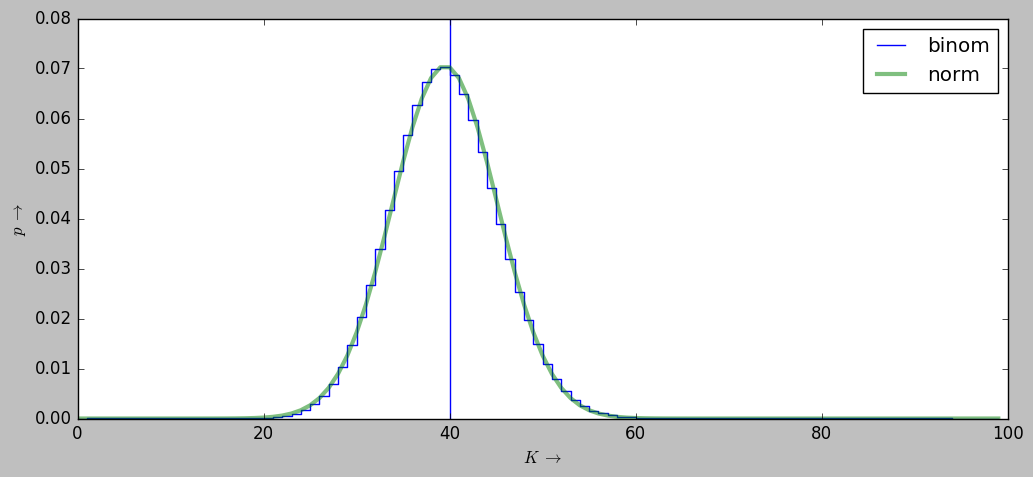

In [69]:
p = 0.2 
binom = scipy.stats.binom(n = 200, p = p)
K = np.arange(0, 100)
p_binom = binom.pmf(K)
m_binom = binom.mean()
s_binom = binom.std()
print("Mittelwert:\t{0:.3g}".format(m_binom))
print("Std.abweichung:\t{0:.3g}".format(binom.std()))
print("Varianz:\t{0:.3g}".format(binom.var()))
plt.step(K, p_binom, label='binom')
plt.axvline(x=m_binom)
plt.xlabel(r"$K \; \rightarrow$"); plt.ylabel(r"$p \; \rightarrow$")

norm = scipy.stats.norm(loc = m_binom, scale = s_binom) # "frozen" distribution mit m und sigma
p_norm = norm.pdf(K+0.5) # continuous distribution, berechne probability density function
plt.plot(K, p_norm, lw = 3, alpha = 0.5, label='norm')
plt.legend()
plt.show()

Die Wahrscheinlichkeit dafür dass $K$ z.B. maximal 50 ist, erhält man aus der Verteilungsfunktion (*cumulative distribution function*, cdf). Diese Funktion lässt sich nicht geschlossen angeben, aber gut durch eine Fehlerfunktion annähern, wenn (Faustregel) die Varianz größer als 9 bzw. die Standardabweichung > 3 ist. Das ist in dem Beispiel hier gegeben. Die Verteilungsfunktionen in Python erhält man über die Methoden
`stats.binom.cdf()` bzw.
`stats.norm.cdf()`.

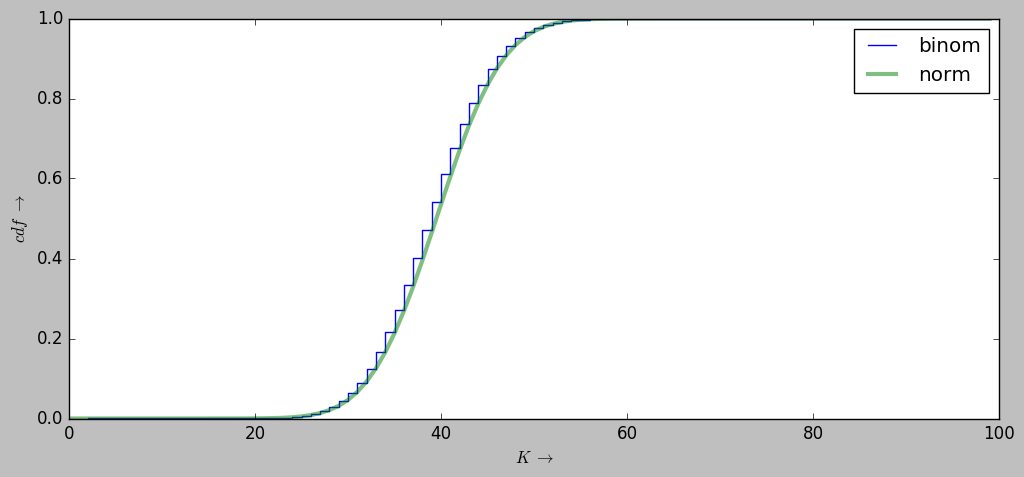

In [72]:
c_binom = binom.cdf(K)
plt.step(K, c_binom, label='binom')
plt.xlabel(r"$K \;\rightarrow$"); plt.ylabel(r"$cdf \;\rightarrow$");

norm = scipy.stats.norm(loc = m_binom, scale = s_binom) 
c_norm = norm.cdf(K+0.5) # continuous distribution
plt.plot(K, c_norm, lw = 3, alpha = 0.5, label='norm')
plt.legend()
plt.show()

Die Frage am Anfang des Notebooks war ja: Wie groß ist die Wahrscheinlichkeit, dass 10 von 10 Experimenten einer Bernoulli - Verteilung mit $p = 0.2$ erfolgreich sind? Die mathematische Beschreibung ist 

$
P(K, L, p) = \binom{L}{K} p^K q^{L-K} = \frac{L!}{K!(L-K)!} p^K q^{L-K}
$
mit $K = L = 10$. 

Es ist also $P(K=10, L=10, p=0.2) = 0.2^{10} = 1.024 \cdot 10^{-7}$

oder in Python: 

In [ ]:
print("P(p=0.2, K=10, L=10) = 0.2^10\t= {0:g}".format(0.2**10))
print("binom.pmf(p=0.2, n=10, k=10) \t= {0:g}".format(scipy.stats.binom.pmf(p=0.2, n=10, k=10)))

# Histogramme #
---

Histogramme sind eine übersichtlichere grafische Darstellung der Ergebnisse von Zufallsprozessen. Hierfür muss zunächst festgelegt werden, auf welche *Bins* (Datenbereiche) die Daten verteilt werden sollen. Die Gesamtbreite sollte alle Daten erfassen. Ein einfaches Beispiel ist die Darstellung, wie viele Bernoulli-Experimente eine 0 und wieviele eine 1 ergeben. Hierfür ist die `numpy.histogram(data, bins)` Funktion hilfreich:

In [57]:
# Testdaten 
data = scipy.stats.bernoulli.rvs(size=10, p=0.2)

#Aufteilung der Daten in 3 Bins (Angabe der Kanten des Histogramms)
hist, bin_edges = np.histogram(data, bins=[-0.01, 0.01, 0.99, 1.01])

for i in range(len(hist)):
    print('{} Samples zwischen {} and {}'.format(hist[i], bin_edges[i], bin_edges[i + 1]))

8 Samples zwischen -0.01 and 0.01
0 Samples zwischen 0.01 and 0.99
2 Samples zwischen 0.99 and 1.01


In [58]:
# Histogramm mit zwei Bins
hist, bin_edges = np.histogram(data, bins=[-0.5, 0.5, 1.5])

for i in range(len(hist)):
    print('{} Samples zwischen {} and {}'.format(hist[i], bin_edges[i], bin_edges[i + 1]))

8 Samples zwischen -0.5 and 0.5
2 Samples zwischen 0.5 and 1.5


Meist ist es interessanter, die Mitte der Bins anzugeben als die Kanten:

In [59]:
#bin_edges = np.arange(0,10,1)
#bin_edges = np.logspace(0,1,10)

print("Alle Kanten:\t{0}".format(bin_edges))
print("Obere Kanten:\t{0}".format(bin_edges[1:]))
print("Untere Kanten:\t{0}".format(bin_edges[:-1]))

#calculate average of neighbor bins
bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
print("Kantenmitten:\t{0}".format(bin_centers))

Alle Kanten:	[-0.500  0.500  1.500]
Obere Kanten:	[ 0.500  1.500]
Untere Kanten:	[-0.500  0.500]
Kantenmitten:	[ 0.000  1.000]


In [60]:
for i in range(len(hist)):
    print('{} Samples bei {}'.format(hist[i], bin_centers[i]))

8 Samples bei 0.0
2 Samples bei 1.0


Mit der Matplotlib-Funktion `bar()` kann man Histogramme grafisch darstellen:

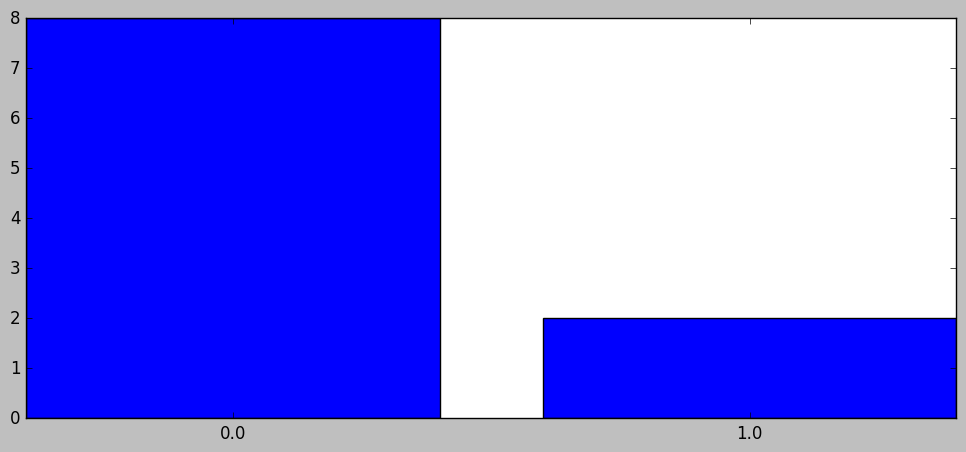

In [61]:
plt.bar(bin_centers, hist, tick_label=bin_centers, align='center')
plt.show()

Das `plt.hist` Kommando versucht, Histogramme automatisch darzustellen. Beispiel Normalverteilung: 


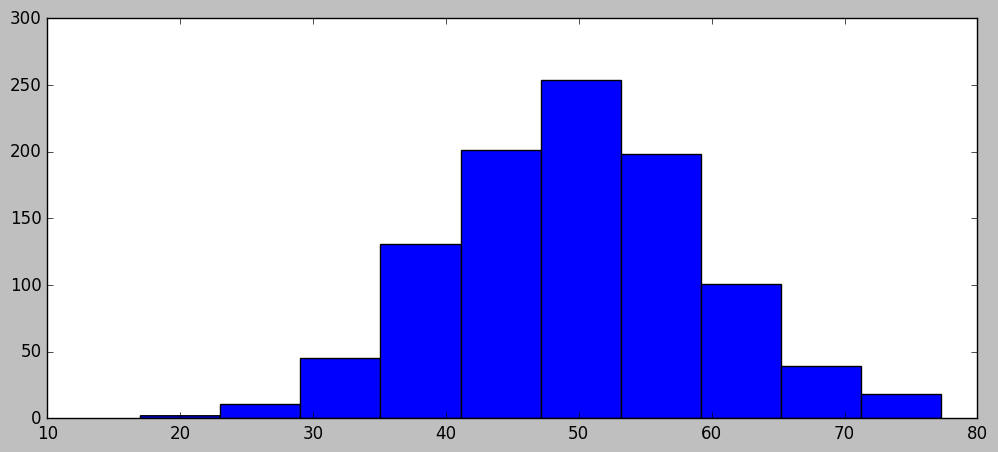

In [62]:
data = scipy.stats.norm.rvs(loc = 50, scale = 10, size=1000)
plt.hist(data)
plt.show()

Die anzuzeigenden Bins können optional spezifiziert werden:

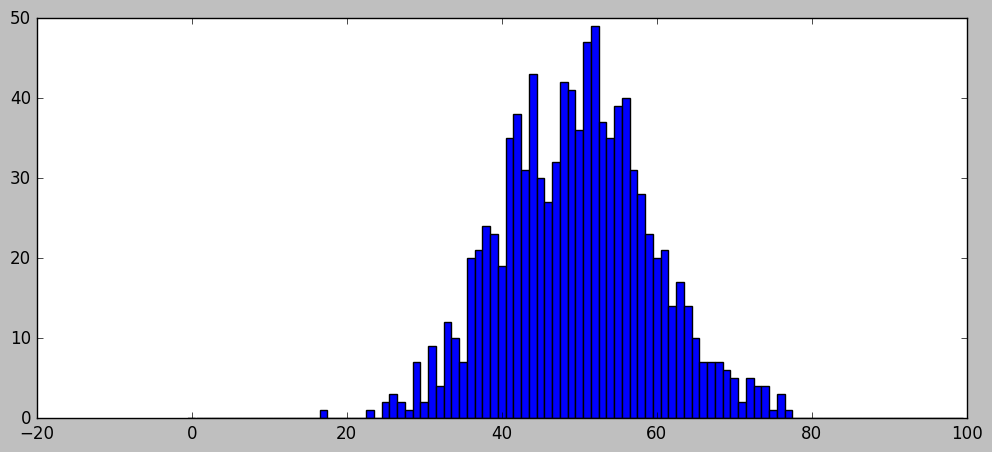

In [63]:
plt.hist(data, bins=np.arange(-0.5,100.5,1))
plt.show()

# Scatterplots
Für Korrelationsmessungen etc. ist es oft interessant, die Daten als Punktwolke darzustellen:

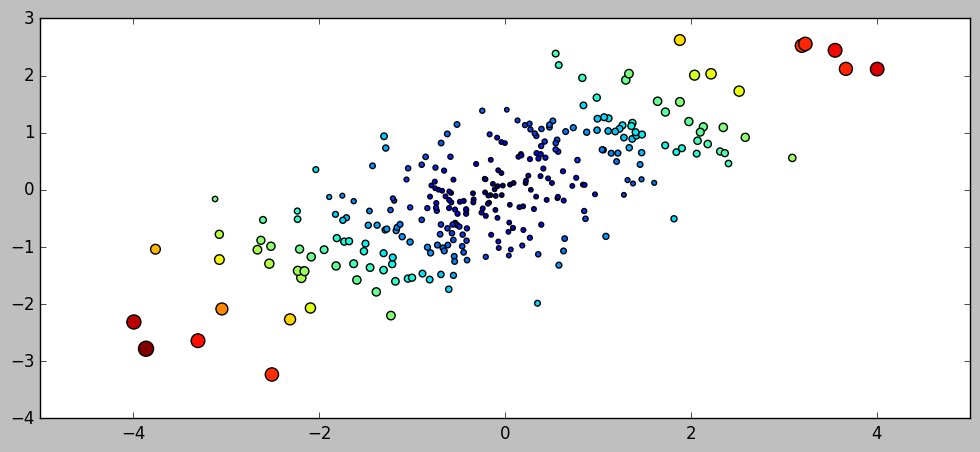

In [68]:
x = scipy.stats.norm.rvs(size=300)
y = x + scipy.stats.norm.rvs(size=300)

#plt.plot(x,y, 'o')
plt.scatter(y,x, s = 10 + 10* abs(x*y), c=abs(x) + abs(y))
plt.show()